In [349]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import math
import os
from filterpy.kalman import KalmanFilter

In [591]:
filePath = 'data/robot/test1_rec.txt'
targets = np.loadtxt(filePath)[1000:1200,0:3]
targets.shape

(200, 3)

(-0.25, 0.25)

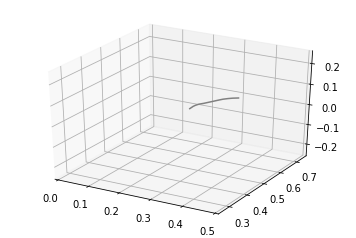

In [572]:
fig = plt.figure()
ax = plt.axes(projection='3d')
p = ax.plot3D(targets[:,0], targets[:,1], targets[:,2], 'gray')
ax.set_xlim(0.0,0.5)
ax.set_ylim(0.25,0.75)
ax.set_zlim(-0.25,0.25)

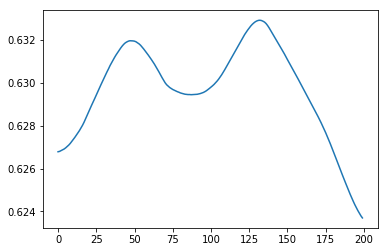

In [573]:
p = plt.plot(targets[:,1])

In [592]:
data = np.load('data/data-out_2020-03-05_18-08.npy')[:,:,:200]
#data = np.load('data/data-ex_2020-03-05_18-08.npy')[:,:,:100]
[t,n,s] = data.shape
print(data.shape)

(25, 72, 200)


In [627]:
binSize = 10

# Train data
train = np.array([np.mean(data[:24,:,i:i+binSize], axis=2) for i in range(s-binSize)])
print(train.shape)

trainSpikes = np.moveaxis(train, 0, 2)
print(trainSpikes.shape)

B, N, T = np.shape(trainSpikes)
x = np.hstack(tuple( trainSpikes[i,:,:] for i in range(B) ))
x = np.insert(x, 0, 1.0, axis=0)  # Add intercept
print(x.shape)

# Test data
test = np.array([np.mean(data[24,:,i:i+binSize], axis=1) for i in range(s-binSize)])
print(test.shape)

testSpikes = np.moveaxis(test, 0, 1)
print(testSpikes.shape)

Nt, Tt = np.shape(testSpikes)
xe = testSpikes
xe = np.insert(xe, 0, 1.0, axis=0)  # Add intercept
print(xe.shape)

(190, 24, 72)
(24, 72, 190)
(73, 4560)
(190, 72)
(72, 190)
(73, 190)


In [628]:
import statsmodels.api as sm
from scipy.signal import savgol_filter
import time
import sys

def estimate(target):
    # Fit
    y = np.tile(target, B)
    model = sm.OLS(y, x.T)
    params = model.fit_regularized(alpha=0.0, L1_wt=0.0).params
    
    # Predict
    ye = np.dot(xe.T, params)
    
    return ye

In [343]:
import statsmodels.api as sm
from scipy.signal import savgol_filter
import time
import sys

[t,n,s] = data.shape
binSize = 100
l = s-binSize

# TODO
# * do regression for at least 2 time steps
def estimate(target):
    yes = []
    t0 = time.time()
    for i in range(l):
        # Fit
        x = np.mean(data[:24,:,i:i+binSize], axis=2)
        y = np.tile(target[i], 24)
        model = sm.OLS(y, x)
        params = model.fit_regularized(alpha=0.0, L1_wt=0.0).params
        
        # Predict
        xe = np.mean(data[24,:,i:i+binSize], axis=1)
        ye = np.dot(xe.T, params)
        yes.append(ye)
        
        # Progress
        t1 = time.time()
        print("{}/{}, t = {}".format(i+1, l, np.round(t1-t0,2)), end="\r")
    return np.array(yes)

In [629]:
#tgtSin = 1.0-0.1*np.sin((np.pi/(0.3*l))*np.arange(l))
#tgtLin = 1+np.arange(l)/l
#tgtExp = np.exp(0.1*np.arange(l)/l)
#tgtCon = np.repeat(1.0, l)

tgt = targets[:-binSize,:]

x1 = estimate(tgt[:,0])
x2 = estimate(tgt[:,1])
x3 = estimate(tgt[:,2])

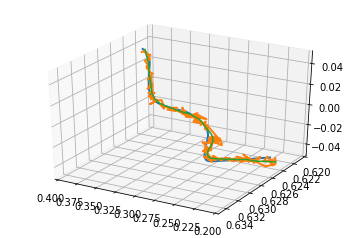

In [630]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(tgt[:,0], tgt[:,1], tgt[:,2], linewidth=2.0)
ax.plot3D(x1, x2, x3, linewidth=2.0)
ax.plot3D(savgol_filter(x1, 21, 1), savgol_filter(x2, 21, 1), savgol_filter(x3, 21, 1))
ax.set_xlim(0.2,0.4)
ax.set_ylim(0.62,0.635)
ax.set_zlim(-0.05,0.05)
ax.view_init(30, 120)

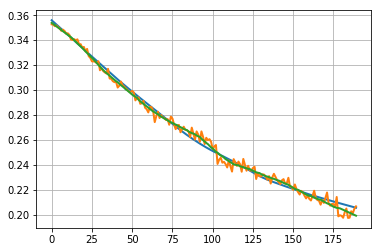

In [631]:
plt.plot(tgt[:,0], linewidth=2.0)
#plt.plot(savgol_filter(yes3, 201, 1), linewidth=3.0)
plt.plot(x1, linewidth=2.0)
plt.plot(savgol_filter(x1, 21, 1), linewidth=2.0)
#plt.xlim((0,100))
#plt.ylim((0.6,0.65))
plt.grid()

p = plt.show()

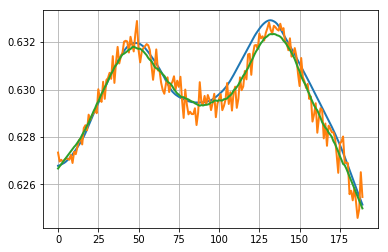

In [632]:
plt.plot(tgt[:,1], linewidth=2.0)
#plt.plot(savgol_filter(yes3, 201, 1), linewidth=3.0)
plt.plot(x2, linewidth=2.0)
plt.plot(savgol_filter(x2, 21, 1), linewidth=2.0)
#plt.xlim((0,100))
#plt.ylim((0.6,0.65))
plt.grid()

p = plt.show()

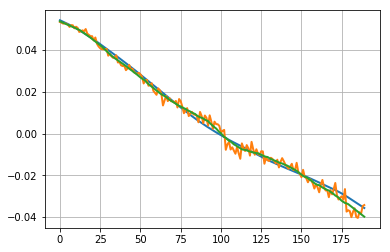

In [633]:
plt.plot(tgt[:,2], linewidth=2.0)
#plt.plot(savgol_filter(yes3, 201, 1), linewidth=3.0)
plt.plot(x3, linewidth=2.0)
plt.plot(savgol_filter(x3, 21, 1), linewidth=2.0)
#plt.xlim((0,100))
#plt.ylim((0.6,0.65))
plt.grid()

p = plt.show()

In [619]:
#my_filter = KalmanFilter(dim_x=2, dim_z=1)
